# 2. Method chaining

Many chaining-friendly methods such as:

- `.assign`
- `.pipe`
- `.rename`/`.rename_axis`
- Window methods: `.rolling`
- `.resample`
- `.where` and `mask` and Indexers accept lambdas

## Data

In [1]:
%matplotlib inline

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import prep
import seaborn as sns

# sns.set(style='ticks', context='talk')

/Users/pcosta/Library/Caches/pypoetry/virtualenvs/modern-pandas-gheCaqJK-py3.8/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
def read(fp):
    df = (
        pd.read_csv(fp)
        .rename(columns=str.lower)
#         .drop("unnamed: 36", axis=1)
        .pipe(extract_city_name)
        .pipe(
            time_to_datetime, ["dep_time", "arr_time", "crs_arr_time", "crs_dep_time"]
        )
        .assign(
            fl_date=lambda x: pd.to_datetime(x["fl_date"]),
            dest=lambda x: pd.Categorical(x["dest"]),
            origin=lambda x: pd.Categorical(x["origin"]),
            tail_num=lambda x: pd.Categorical(x["tail_num"]),
            unique_carrier=lambda x: pd.Categorical(x["unique_carrier"]),
            cancellation_code=lambda x: pd.Categorical(x["cancellation_code"]),
        )
    )
    return df


def extract_city_name(df):
    """
    Chicago, IL -> Chicago for origin_city_name and dest_city_name
    """
    cols = ["origin_city_name", "dest_city_name"]
    city = df[cols].apply(lambda x: x.str.extract("(.*), \w{2}", expand=False))
    df = df.copy()
    df[["origin_city_name", "dest_city_name"]] = city
    return df


def time_to_datetime(df, columns):
    """
    Combine all time items into datetimes.

    2014-01-01,0914 -> 2014-01-01 09:14:00
    """
    df = df.copy()

    def converter(col):
        timepart = (
            col.astype(str)
            .str.replace("\.0$", "")  # NaNs force float dtype
            .str.pad(4, fillchar="0")
        )
        return pd.to_datetime(
            df["fl_date"]
            + " "
            + timepart.str.slice(0, 2)
            + ":"
            + timepart.str.slice(2, 4),
            errors="coerce",
        )

    df[columns] = df[columns].apply(converter)
    return df


output = "data/flights.h5"

if not os.path.exists(output):
    df = read("data/307021124_T_ONTIME.csv")
    df.to_hdf(output, "flights", format="table")
else:
#     df = read("data/307021124_T_ONTIME.csv")
    df = pd.read_hdf(output, "flights")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450017 entries, 0 to 450016
Data columns (total 33 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   fl_date                450017 non-null  datetime64[ns]
 1   unique_carrier         450017 non-null  category      
 2   airline_id             450017 non-null  int64         
 3   tail_num               449378 non-null  category      
 4   fl_num                 450017 non-null  int64         
 5   origin_airport_id      450017 non-null  int64         
 6   origin_airport_seq_id  450017 non-null  int64         
 7   origin_city_market_id  450017 non-null  int64         
 8   origin                 450017 non-null  category      
 9   origin_city_name       450017 non-null  object        
 10  dest_airport_id        450017 non-null  int64         
 11  dest_airport_seq_id    450017 non-null  int64         
 12  dest_city_market_id    450017 non-null  int6

## Inspecting chains

[Tom Augspurger](https://tomaugspurger.github.io/method-chaining) wrote some decorators you can use to inspect and log DataFrame properties in between chain steps.

In [9]:
from functools import wraps
import logging

def log_shape(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        logging.info("%s,%s" % (func.__name__, result.shape))
        return result
    return wrapper

def log_dtypes(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        logging.info("%s,%s" % (func.__name__, result.dtypes))
        return result
    return wrapper


@log_shape
@log_dtypes
def load(fp):
    df = pd.read_csv(fp, index_col=0, parse_dates=True)

@log_shape
@log_dtypes
def update_events(df, new_events):
    df.loc[new_events.index, 'foo'] = new_events
    return df

## Inplace argument 

Many Pandas methods have an `inplace` keyword that is `False` by default. Keep it that way.

## Examples

<div class="alert alert-block alert-info">
    <b>Techniques of note</b>
    <br><br>
    <li><b><code>DataFrame.loc[lambda: ...]</code></b> for chaining and filtering</li>
    <li><b><code>pd.Grouper</code></b> for resampling while using <code>.groupby</code></li>
    <li><b><code>.unstack</code></b> for easy pivoting</li>
    <li><b><code>.rolling</code></b> for resampling via rows</li>
    <li><b><code>.pipe</code></b> for evaluating functions in chains</li>
    <li><b><code>.assign</code></b> for adding new columns in chains</li>
</div>

In [30]:
df.head()

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin_airport_id,origin_airport_seq_id,origin_city_market_id,origin,origin_city_name,...,arr_time,arr_delay,cancelled,cancellation_code,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,unnamed: 32
0,2017-01-01,AA,19805,N3GNAA,2186,14100,1410002,34100,PHL,Philadelphia,...,2017-01-01 07:31:00,-19.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01,AA,19805,N3KAAA,2189,11298,1129804,30194,DFW,Dallas/Fort Worth,...,2017-01-01 20:23:00,-4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-01,AA,19805,N3LFAA,2190,11298,1129804,30194,DFW,Dallas/Fort Worth,...,2017-01-01 00:04:00,16.0,0.0,NaN,0.0,0.0,16.0,0.0,0.0,NaN
3,2017-01-01,AA,19805,N3DDAA,2191,11697,1169704,32467,FLL,Fort Lauderdale,...,2017-01-01 15:28:00,-10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-01,AA,19805,N3HLAA,2192,11278,1127803,30852,DCA,Washington,...,2017-01-01 20:53:00,12.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


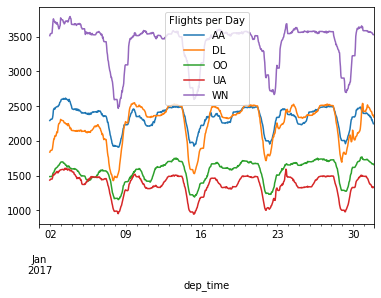

In [14]:
(
    # Drop rows with missing values in "dep_time" or "unique_carrier"
    df.dropna(subset=["dep_time", "unique_carrier"])
    # Look only at the top 5 most popular carriers
    .loc[
        lambda _df: _df["unique_carrier"].isin(
            _df["unique_carrier"].value_counts().index[:5]
        )
    ]
    # Set the time as the index
    .set_index("dep_time")
    # Group by both the unique carrier and by each our on the index
    .groupby(["unique_carrier", pd.Grouper(freq="H")])
    # Get the number of "fl_num", this is the total number of flight
    .fl_num.count()
    # Pivot the table so the index values become the columns
    .unstack("unique_carrier")
    # My addition. Since column is categorical we need to drop all these
    # empty columns
    .loc[:, lambda _df: _df.columns[0 < _df.sum()]]
    # Fill missing values with 0
    .fillna(0)
    # Get the sum from the previous 24 rows
    .rolling(24).sum()
    # Rename
    .rename_axis("Flights per Day", axis="columns")
    # Plot
    .plot()
)

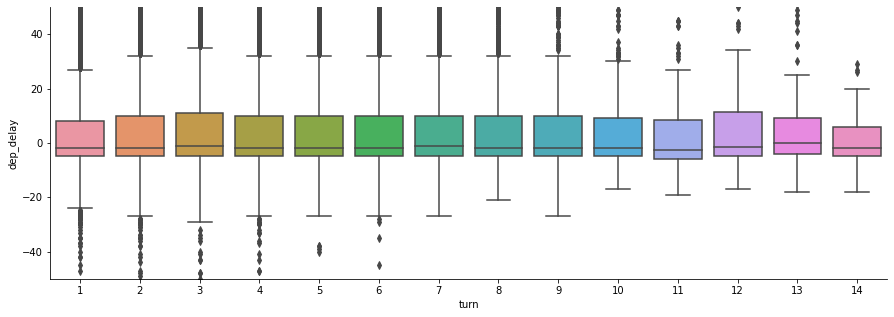

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_ylim(-50, 50)
sns.despine()
(
    df[["fl_date", "tail_num", "dep_time", "dep_delay"]]
    .dropna()
    .sort_values("dep_time")
    .loc[lambda _df: _df.dep_delay < 500]
    .assign(
        turn=lambda _df: _df.groupby(["fl_date", "tail_num"])
        .dep_time.transform("rank")
        .astype(int)
    )
    # Pipe is powerful! Use a string as a keyword here if the dataframe
    # is not the first argument of the function
    # Note we can also pass **kwargs
    .pipe((sns.boxplot, "data"), x="turn", y="dep_delay", ax=ax)
)

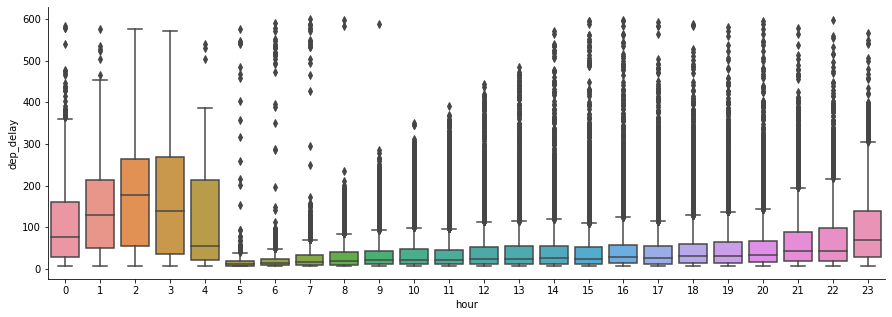

In [26]:
plt.figure(figsize=(15, 5))
(
    df[["fl_date", "tail_num", "dep_time", "dep_delay"]]
    .dropna()
    .assign(hour=lambda x: x.dep_time.dt.hour)
    .query("5 < dep_delay < 600")
    .pipe((sns.boxplot, "data"), "hour", "dep_delay")
)
sns.despine()

I liked this example from [Chang Hsin Lee](https://changhsinlee.com/pyjanitor/) on using the `lambda` function to help with method chaining.

```python
import pandas as pd

raw_data = pd.read_csv("sales.csv")
df = (
    raw_data.assign(order_date=lambda _df: pd.to_datetime(_df["order_date"]))[
        lambda _df: _df["order_date"] >= pd.to_datetime("2019-11-09")
    ]
    .groupby(["category"], axis=1)
    .agg({"dollars": "sum", "volume": "sum",})
)
```

Another good method chaining example from [dataschool](https://www.dataschool.io/future-of-pandas/#methodchaining) with using `lambda` with `.assign`

```python
import pandas as pd

(
    pd.read_csv("data/titanic.csv.gz")
    .query("Age < Age.quantile(.99)")
    .assign(
        Sex=lambda df: df["Sex"].replace({"female": 1, "male": 0}),
        Age=lambda df: pandas.cut(
            df["Age"].fillna(df.Age.median()),
            bins=[df.Age.min(), 18, 40, df.Age.max()],
            labels=["Underage", "Young", "Experienced"],
        ),
    )
    .pivot_table(values="Sex", columns="Pclass", index="Age", aggfunc="mean")
    .rename_axis("", axis="columns")
    .rename("Class {}".format, axis="columns")
    .style.format("{:.2%}")
)
```